In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, make_circles
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import sys
sys.path.append('../') 
from nn.swarm_perceptron_qpso import perceptron 

# MSE Score

In [26]:
def load_data(data_name):
    if data_name == "iris":
        data = load_iris()
        return data.data, data.target
    elif data_name == "wine":
        data = load_wine()
        return data.data, data.target
    elif data_name == "breast":
        data = load_breast_cancer()
        return data.data, data.target
    else:
        n = 500 #register number
        #generating the input X and output y (binary vector)
        X, y = make_circles(n_samples=n, factor=0.5, noise=0.05)
        y = y[:, np.newaxis]
        return X, np.array(y).reshape((n,))

In [27]:
def calculate_score(nn, X_train, y_train, X_test, y_test, X_val, y_val, parameters):
    # Predicción y costo para el conjunto de prueba
    y_train_pred = np.argmax(nn.forward(X_train, parameters), axis=1)
    cost_train = mean_squared_error(y_train, y_train_pred)
    # Predicción y costo para el conjunto de prueba
    y_test_pred = np.argmax(nn.forward(X_test, parameters), axis=1)
    cost_test = mean_squared_error(y_test, y_test_pred)
    # Predicción y costo para el conjunto de validación
    y_val_pred = np.argmax(nn.forward(X_val, parameters), axis=1)
    cost_val = mean_squared_error(y_val, y_val_pred)  
    return cost_train, cost_test, cost_val

In [28]:
def score_nn(data_name, data):
    X_org, y_org = load_data(data_name)
    #print('Shape of X: ', X_org.shape)
    #print('Shape of y: ', y_org.shape)

    # normalize data (0,1)
    t = MinMaxScaler()
    t.fit(X_org)
    X_org = t.transform(X_org)

    # Primero dividimos los datos en entrenamiento(80%) y testeo(20%)
    X_train_aux, X_test_bal, y_train_aux, y_test_bal = train_test_split(X_org, y_org, test_size=0.2, random_state=100)
    # Luego dividimos el conjunto de entrenamiento(80%) en entrenamiento(87.5% del 80% => 70% del total) y validación(12.5% del 80% => 10% del total)
    X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(X_train_aux, y_train_aux, test_size=0.125, random_state=100)    

    #print(f"Training target statistics: {Counter(y_train_bal), len(y_train_bal)}")
    #print(f"Testing target statistics: {Counter(y_test_bal), len(y_test_bal)}")
    #print(f"Validation target statistics: {Counter(y_val_bal), len(y_val_bal)}")
    
    X_sample = len(X_train_bal)
    X_input = len(X_train_bal[1])
    X_class = len(np.unique(y_train_bal))

    X_train = X_train_bal
    y_train = y_train_bal
    X_test = X_test_bal
    y_test = y_test_bal
    X_val = X_val_bal
    y_val = y_val_bal

    # load perceptron
    nn = perceptron(X_sample, X_input, X_class)
    score_train, score_test, score_val = calculate_score(nn, X_train, y_train, X_test, y_test, X_val, y_val, data)
    return score_train, score_test, score_val

In [29]:
#file_path = '../output/exchange_layers/breast/20/20/qdpso_breast_gBest_113_20_20_30.npy'
#data = np.load(file_path)
#print(data.shape)
#score_train, score_test, score_val = score_nn('breast', data)
#print (score_train, score_test, score_val)

In [30]:
# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers', 'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Directorio base donde se encuentran los archivos
base_dir = '../output'
values_array = []

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        for max_iter in max_iters:
            for n_particle in n_particulas:
                # Definir el valor de X_input en función de data_name
                if data_name == "circle":
                    X_input = 2
                elif data_name == "iris":
                    X_input = 4
                elif data_name == "wine":
                    X_input = 13
                elif data_name == "breast":
                    X_input = 30
                
                # Construir la ruta al archivo
                file_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_gBest_113_{n_particle}_{max_iter}_{X_input}.npy'
                time_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/{data_name}_{max_iter}_{n_particle}_start_end_execution_time.npy'

                try:
                    # Intentar cargar el archivo numpy
                    data = np.load(file_path)
                    time = np.load(time_path)

                    values_dict = {}
                    score_values = {}
                    score_train, score_test, score_val = score_nn(data_name, data)

                    score_values["score_train"] = score_train
                    score_values["score_test"] = score_test
                    score_values["score_val"] = score_val

                    values_dict["training_type"] = training_type
                    values_dict["data_name"] = data_name
                    values_dict["max_iter"] = max_iter
                    values_dict["n_particle"] = n_particle
                    values_dict["score"] = score_values
                    values_dict["exec"] = time[2]
                    
                    # Realizar cualquier análisis que desees con 'data'
                    # Por ejemplo, imprimir la forma de los datos
                    print(f'Archivo cargado: {file_path}, Forma de los datos: {data.shape}, score train: {score_train}, score test: {score_test}, score val: {score_val}')
                    #print(time_path)
                    print(f'time: {time}')
                    values_array.append(values_dict)
                    
                except FileNotFoundError:
                    print(f'Archivo no encontrado: {file_path}')
                except Exception as e:
                    print(f'Error al cargar el archivo {file_path}: {str(e)}')


Archivo cargado: ../output/exchange_layers/breast/20/20/qdpso_breast_gBest_113_20_20_30.npy, Forma de los datos: (2972,), score train: 0.05527638190954774, score test: 0.008771929824561403, score val: 0.05263157894736842
time: [18261.2474057 18325.1544773    63.9070716]
Archivo cargado: ../output/exchange_layers/breast/20/40/qdpso_breast_gBest_113_40_20_30.npy, Forma de los datos: (2972,), score train: 0.05527638190954774, score test: 0.02631578947368421, score val: 0.017543859649122806
time: [18325.1555817 18435.6441435   110.4885618]
Archivo cargado: ../output/exchange_layers/breast/20/60/qdpso_breast_gBest_113_60_20_30.npy, Forma de los datos: (2972,), score train: 0.05025125628140704, score test: 0.03508771929824561, score val: 0.05263157894736842
time: [18435.6452974 18589.6819246   154.0366272]
Archivo cargado: ../output/exchange_layers/breast/20/80/qdpso_breast_gBest_113_80_20_30.npy, Forma de los datos: (2972,), score train: 0.06030150753768844, score test: 0.008771929824561403

In [31]:
print(np.array(values_array).shape)
print(values_array[0])


(840,)
{'training_type': 'exchange_layers', 'data_name': 'breast', 'max_iter': 20, 'n_particle': 20, 'score': {'score_train': 0.05527638190954774, 'score_test': 0.008771929824561403, 'score_val': 0.05263157894736842}, 'exec': 63.907071599998744}


In [32]:
import os

print("Directorio de trabajo actual:", os.getcwd())
print("Archivos en el directorio:", os.listdir('../output/individual_layers/'))


Directorio de trabajo actual: c:\Users\USER\Documents\qdpso\repo\nn_qdpso\swarm-qpso-nn\src\graphics
Archivos en el directorio: ['breast', 'circle', 'iris', 'wine']


In [33]:
#import pandas as pd

# Convertir la lista de diccionarios en un DataFrame
#df = pd.DataFrame(values_array)

# Extraer las claves del diccionario anidado en la columna 'score' y convertirlas en columnas
#scores_df = df['score'].apply(pd.Series)

# Concatenar las nuevas columnas de puntuación con el DataFrame original
#df = pd.concat([df.drop(['score'], axis=1), scores_df], axis=1)

# Iterar sobre cada grupo de 'training_type' y crear un archivo CSV para cada uno
#for training_type, group_df in df.groupby('training_type'):
#    group_df.to_csv(f"./results/training_type/{training_type}.csv", index=False)


In [34]:
import pandas as pd

# Convertir la lista de diccionarios en un DataFrame
df = pd.DataFrame(values_array)

# Extraer las claves del diccionario anidado en la columna 'score' y convertirlas en columnas
scores_df = df['score'].apply(pd.Series)

# Concatenar las nuevas columnas de puntuación con el DataFrame original
df = pd.concat([df.drop(['score'], axis=1), scores_df], axis=1)

# Iterar sobre cada grupo de 'data_name' y crear un archivo CSV para cada uno
for data_name, group_df in df.groupby('data_name'):
    group_df.to_csv(f"./results/datasets/{data_name}.csv", index=False)



# Time Analysis

In [35]:
import pandas as pd

# Cargar el archivo Excel
file_path = './results/bt.xlsx'
data = pd.read_excel(file_path)

# Eliminar filas completamente vacías, si las hay
data_cleaned = data.dropna(how='all').reset_index(drop=True)

# Renombrar las columnas para una mejor comprensión (opcional)
column_names = ['Max Iteraciones', 'Número de Partículas', 'Paralelización Intercambio Layers', 
                'Paralelización', 'Concurrencia e Intercambio Iteraciones', 
                'Concurrencia e Intercambio Iteraciones + Layer', 'Sin Paralelización', 
                'Sin Paralelización e Intercambio Layers']
data_cleaned.columns = column_names

# Mostrar la tabla ajustada
print(data_cleaned)


    Max Iteraciones  Número de Partículas  Paralelización Intercambio Layers  \
0              20.0                    20                          63.907072   
1               NaN                    40                         110.488562   
2               NaN                    60                         154.036627   
3               NaN                    80                         200.110051   
4               NaN                   100                         244.179926   
5              40.0                    20                         112.826593   
6               NaN                    40                         202.664639   
7               NaN                    60                         288.868017   
8               NaN                    80                         381.048161   
9               NaN                   100                         464.327710   
10             60.0                    20                         160.438499   
11              NaN                    4

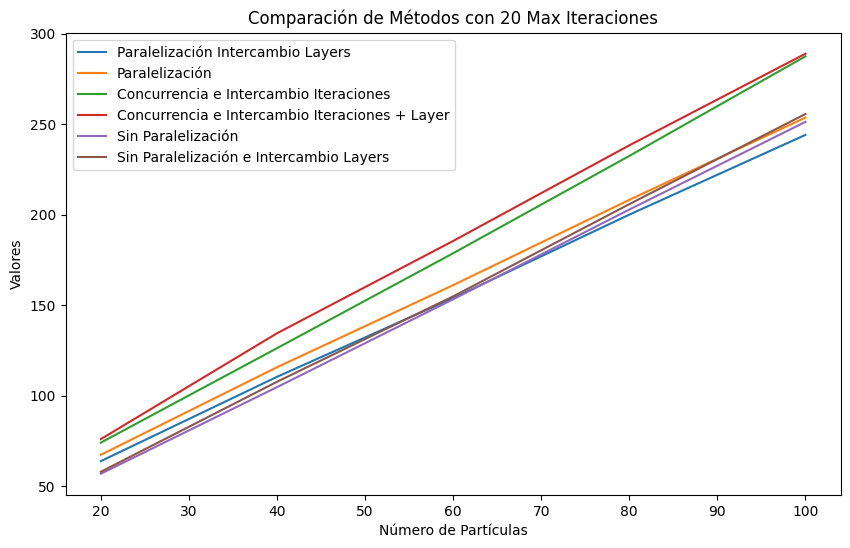

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar el archivo Excel
file_path = './results/bt.xlsx'
data = pd.read_excel(file_path)

# Realizar limpieza y preparación de datos
data_cleaned = data.dropna(how='all').reset_index(drop=True)
column_names = ['Max Iteraciones', 'Número de Partículas', 'Paralelización Intercambio Layers', 
                'Paralelización', 'Concurrencia e Intercambio Iteraciones', 
                'Concurrencia e Intercambio Iteraciones + Layer', 'Sin Paralelización', 
                'Sin Paralelización e Intercambio Layers']
data_cleaned.columns = column_names

# Tomar los datos correspondientes a '20 max iter'
data_to_plot = data_cleaned.iloc[0:5]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot['Sin Paralelización e Intercambio Layers']

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 20 Max Iteraciones')
plt.legend()

plt.show()

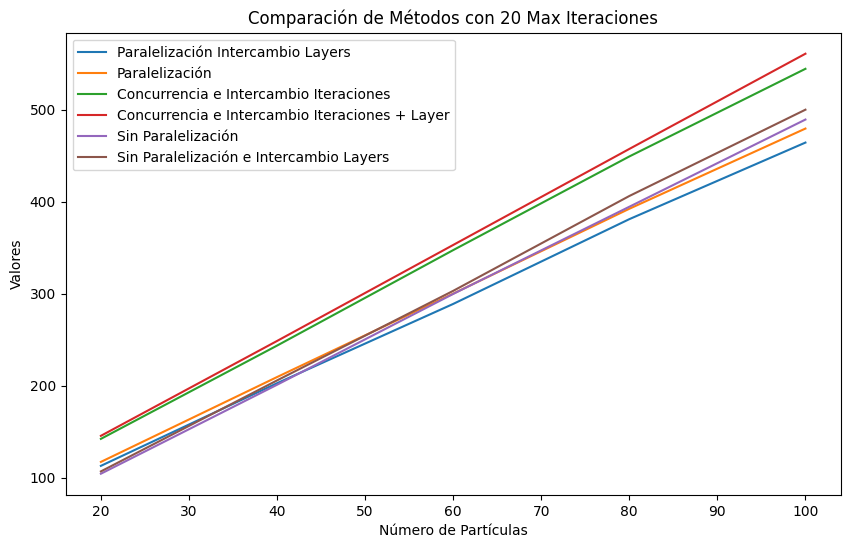

In [49]:
data_to_plot = data_cleaned.iloc[5:10]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot['Sin Paralelización e Intercambio Layers']

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 20 Max Iteraciones')
plt.legend()

plt.show()

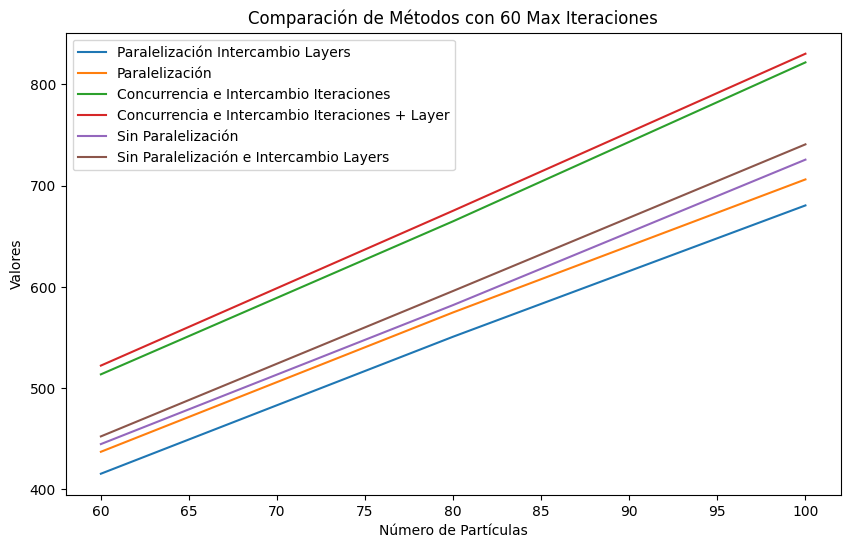

In [38]:
# Tomar los datos correspondientes a '20 max iter'
data_to_plot = data_cleaned.iloc[11:15]
data_to_plot_corrected = data_to_plot.iloc[1:6]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot_corrected['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot_corrected['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot_corrected['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Sin Paralelización e Intercambio Layers']

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 60 Max Iteraciones')
plt.legend()

plt.show()

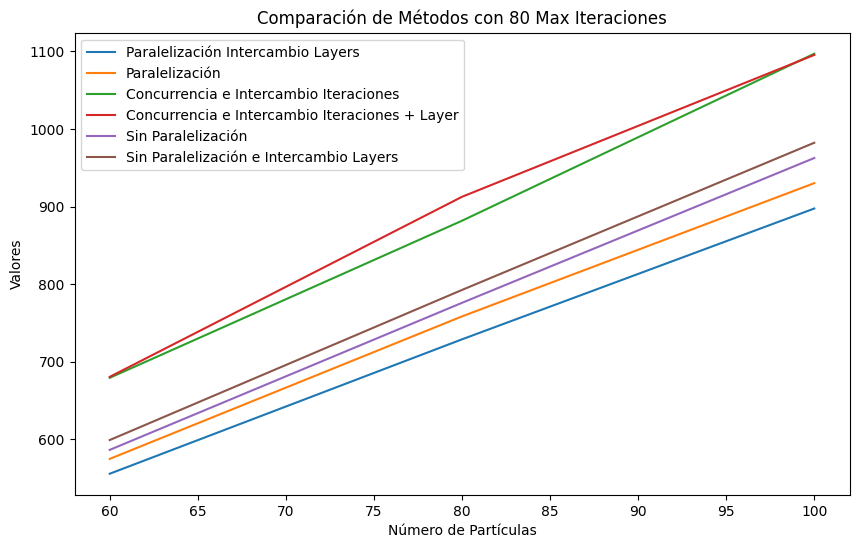

In [39]:
# Tomar los datos correspondientes a '20 max iter'
data_to_plot = data_cleaned.iloc[16:20]
data_to_plot_corrected = data_to_plot.iloc[1:6]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot_corrected['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot_corrected['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot_corrected['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Sin Paralelización e Intercambio Layers']

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 80 Max Iteraciones')
plt.legend()

plt.show()

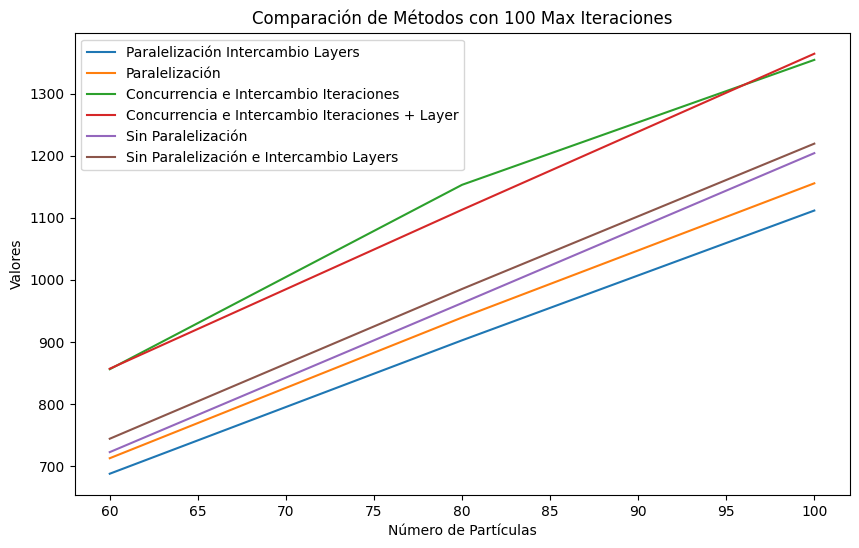

In [40]:
# Tomar los datos correspondientes a '20 max iter'
data_to_plot = data_cleaned.iloc[21:25]
data_to_plot_corrected = data_to_plot.iloc[1:6]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot_corrected['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot_corrected['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot_corrected['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Sin Paralelización e Intercambio Layers']

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 100 Max Iteraciones')
plt.legend()

plt.show()

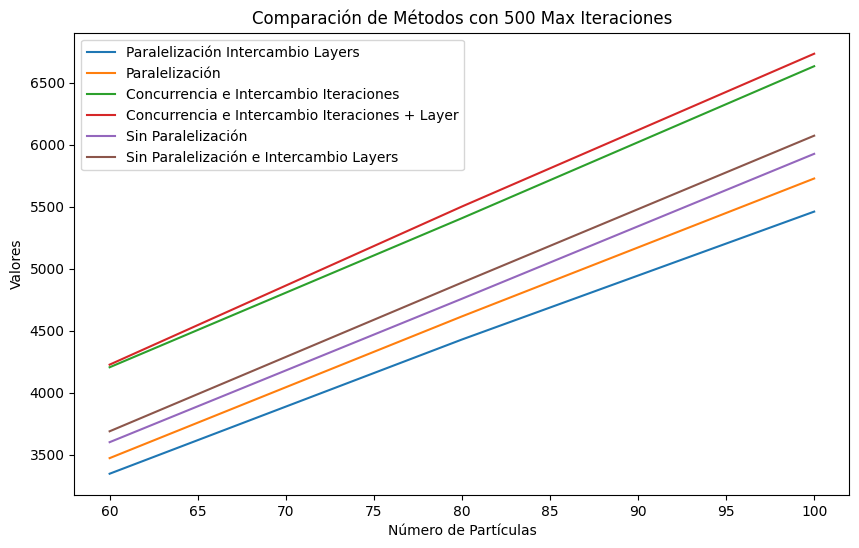

In [41]:
# Tomar los datos correspondientes a '20 max iter'
data_to_plot = data_cleaned.iloc[26:30]
data_to_plot_corrected = data_to_plot.iloc[1:6]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot_corrected['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot_corrected['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot_corrected['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot_corrected['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot_corrected['Sin Paralelización e Intercambio Layers']

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 500 Max Iteraciones')
plt.legend()

plt.show()

In [54]:
# Función para calcular la pendiente promedio
def calcular_pendiente_promedio(x, y):
    pendientes = (y[1:] - y[:-1]) / (x[1:] - x[:-1])
    print(pendientes)
    pendiente_promedio = np.mean(pendientes)
    return pendiente_promedio

Número de Partículas (x): [ 20  40  60  80 100]
Paralelización Intercambio Layers (y): [ 2428.9651394  4602.9303496  6689.1582585  8823.813103  10923.4885089]
Paralelización (y): [ 2468.8370314  4733.837154   6754.6533047  8908.0522162 10997.4377449]
Concurrencia e Intercambio Iteraciones (y): [ 3446.7898285  5864.5347555  8251.9742404 10656.9519062 13087.3988414]
Concurrencia e Intercambio Iteraciones + Layer (y): [ 3514.3556776  5959.754213   8399.9364114 10843.9320246 13245.1499457]
Sin Paralelización (y): [ 2569.3775918  4960.6235067  7255.3593746  9600.0742979 11892.5812819]
Sin Paralelización e Intercambio Layers (y): [ 2663.5648334  5076.3110651  7386.4693722  9800.2766216 12107.3476918]
[108.69826051 104.31139544 106.73274223 104.98377029]
Pendiente Paralelización Intercambio Layers:  106.18154211875
[113.25000613 101.04080754 107.66994557 104.46927644]
Pendiente Paralelización:  106.60750891875001
[120.88724635 119.37197425 120.24888329 121.52234676]
Pendiente Concurrencia e I

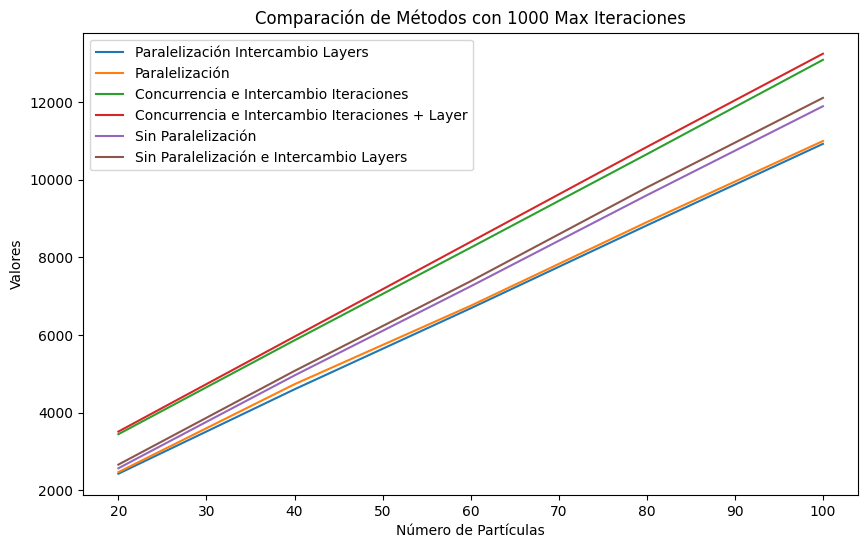

In [57]:
# Tomar los datos correspondientes a '20 max iter'
data_to_plot = data_cleaned.iloc[30:35]

# Extraer el eje x y los datos para las líneas
x_corrected = data_to_plot['Número de Partículas']
y_paralelizacion_intercambio_layers_corrected = data_to_plot['Paralelización Intercambio Layers']
y_paralelizacion_corrected = data_to_plot['Paralelización']
y_concurrencia_intercambio_iteraciones_corrected = data_to_plot['Concurrencia e Intercambio Iteraciones']
y_concurrencia_intercambio_iteraciones_layer_corrected = data_to_plot['Concurrencia e Intercambio Iteraciones + Layer']
y_sin_paralelizacion_corrected = data_to_plot['Sin Paralelización']
y_sin_paralelizacion_intercambio_layers_corrected = data_to_plot['Sin Paralelización e Intercambio Layers']

# Imprimir los valores
print("Número de Partículas (x):", x_corrected.values)
print("Paralelización Intercambio Layers (y):", y_paralelizacion_intercambio_layers_corrected.values)
print("Paralelización (y):", y_paralelizacion_corrected.values)
print("Concurrencia e Intercambio Iteraciones (y):", y_concurrencia_intercambio_iteraciones_corrected.values)
print("Concurrencia e Intercambio Iteraciones + Layer (y):", y_concurrencia_intercambio_iteraciones_layer_corrected.values)
print("Sin Paralelización (y):", y_sin_paralelizacion_corrected.values)
print("Sin Paralelización e Intercambio Layers (y):", y_sin_paralelizacion_intercambio_layers_corrected.values)

print("==============================================================================================================")
print("==============================================================================================================")

# Calcular la pendiente para cada línea
print("Pendiente Paralelización Intercambio Layers: ", calcular_pendiente_promedio(x_corrected.values, y_paralelizacion_intercambio_layers_corrected.values))
print("Pendiente Paralelización: ",calcular_pendiente_promedio(x_corrected.values, y_paralelizacion_corrected.values))
print("Pendiente Concurrencia e Intercambio Iteraciones: ",calcular_pendiente_promedio(x_corrected.values, y_concurrencia_intercambio_iteraciones_corrected.values))
print("Pendiente Concurrencia e Intercambio Iteraciones + Layer: ",calcular_pendiente_promedio(x_corrected.values, y_concurrencia_intercambio_iteraciones_layer_corrected.values))
print("Pendiente Sin Paralelización: ",calcular_pendiente_promedio(x_corrected.values, y_sin_paralelizacion_corrected.values))
print("Pendiente Sin Paralelización e Intercambio Layers: ",calcular_pendiente_promedio(x_corrected.values, y_sin_paralelizacion_intercambio_layers_corrected.values))

# Crear la gráfica con las 6 líneas
plt.figure(figsize=(10, 6))
plt.plot(x_corrected, y_paralelizacion_intercambio_layers_corrected, label='Paralelización Intercambio Layers')
plt.plot(x_corrected, y_paralelizacion_corrected, label='Paralelización')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_corrected, label='Concurrencia e Intercambio Iteraciones')
plt.plot(x_corrected, y_concurrencia_intercambio_iteraciones_layer_corrected, label='Concurrencia e Intercambio Iteraciones + Layer')
plt.plot(x_corrected, y_sin_paralelizacion_corrected, label='Sin Paralelización')
plt.plot(x_corrected, y_sin_paralelizacion_intercambio_layers_corrected, label='Sin Paralelización e Intercambio Layers')

plt.xlabel('Número de Partículas')
plt.ylabel('Valores')
plt.title('Comparación de Métodos con 1000 Max Iteraciones')
plt.legend()

plt.show()


# One Swarm

In [44]:
# Definir las listas de valores posibles para las variables
training_types = ['one_individual_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Directorio base donde se encuentran los archivos
base_dir = '../output'
values_array = []

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        for max_iter in max_iters:
            for n_particle in n_particulas:
                # Definir el valor de X_input en función de data_name
                if data_name == "circle":
                    X_input = 2
                elif data_name == "iris":
                    X_input = 4
                elif data_name == "wine":
                    X_input = 13
                elif data_name == "breast":
                    X_input = 30
                
                # Construir la ruta al archivo
                file_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_gBest_113_{n_particle}_{max_iter}_{X_input}.npy'
                time_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/{data_name}_{max_iter}_{n_particle}_start_end_execution_time.npy'

                try:
                    # Intentar cargar el archivo numpy
                    data = np.load(file_path)
                    time = np.load(time_path)

                    values_dict = {}
                    score_values = {}
                    score_train, score_test, score_val = score_nn(data_name, data)

                    score_values["score_train"] = score_train
                    score_values["score_test"] = score_test
                    score_values["score_val"] = score_val

                    values_dict["training_type"] = training_type
                    values_dict["data_name"] = data_name
                    values_dict["max_iter"] = max_iter
                    values_dict["n_particle"] = n_particle
                    values_dict["score"] = score_values
                    values_dict["exec"] = time[2]
                    
                    # Realizar cualquier análisis que desees con 'data'
                    # Por ejemplo, imprimir la forma de los datos
                    print(f'Archivo cargado: {file_path}, Forma de los datos: {data.shape}, score train: {score_train}, score test: {score_test}, score val: {score_val}')
                    #print(time_path)
                    print(f'time: {time}')
                    values_array.append(values_dict)
                    
                except FileNotFoundError:
                    print(f'Archivo no encontrado: {file_path}')
                except Exception as e:
                    print(f'Error al cargar el archivo {file_path}: {str(e)}')

Archivo cargado: ../output/one_individual_layers/breast/20/20/qdpso_breast_gBest_113_20_20_30.npy, Forma de los datos: (2972,), score train: 0.11055276381909548, score test: 0.043859649122807015, score val: 0.07017543859649122
time: [19346.2009035 19399.0337383    52.8328348]
Archivo cargado: ../output/one_individual_layers/breast/20/40/qdpso_breast_gBest_113_40_20_30.npy, Forma de los datos: (2972,), score train: 0.07537688442211055, score test: 0.06140350877192982, score val: 0.07017543859649122
time: [19399.0351661 19502.9888239   103.9536578]
Archivo cargado: ../output/one_individual_layers/breast/20/60/qdpso_breast_gBest_113_60_20_30.npy, Forma de los datos: (2972,), score train: 0.07035175879396985, score test: 0.043859649122807015, score val: 0.03508771929824561
time: [19502.9903216 19657.9427417   154.9524201]
Archivo cargado: ../output/one_individual_layers/breast/20/80/qdpso_breast_gBest_113_80_20_30.npy, Forma de los datos: (2972,), score train: 0.04773869346733668, score te

In [45]:
import pandas as pd

# Convertir la lista de diccionarios en un DataFrame
df = pd.DataFrame(values_array)

# Extraer las claves del diccionario anidado en la columna 'score' y convertirlas en columnas
scores_df = df['score'].apply(pd.Series)

# Concatenar las nuevas columnas de puntuación con el DataFrame original
df = pd.concat([df.drop(['score'], axis=1), scores_df], axis=1)

# Iterar sobre cada grupo de 'data_name' y crear un archivo CSV para cada uno
for data_name, group_df in df.groupby('data_name'):
    group_df.to_csv(f"./results/one_swarm/{data_name}.csv", index=False)


# AVG Time and Stability

## Time

In [2]:
# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers',  'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers', 'one_individual_layers'] # 'individual_layers',
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Directorio base donde se encuentran los archivos
base_dir = '../output'

# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'avg_exe'])

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        for max_iter in max_iters:
            for n_particle in n_particulas:
                X_input = {'circle': 2, 'iris': 4, 'wine': 13, 'breast': 30}.get(data_name, None)
                
                time_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_training_time.csv'

                try:
                    # Leer el archivo CSV
                    time_data = pd.read_csv(time_path, index_col=0)
                    total_times = []

                    # Recolectar los tiempos
                    for i in range(15):
                        row_index = f'total_training_{i}'
                        if row_index in time_data.index:
                            total_times.append(time_data.loc[row_index].values[0])

                    # Calcular el promedio si hay tiempos disponibles
                    if total_times:
                        avg_time = sum(total_times) / len(total_times)
                        print(f'Promedio de los tiempos de entrenamiento: {avg_time}')

                        # Crear un nuevo DataFrame para esta fila y concatenarlo
                        new_row = pd.DataFrame({
                            'training_type': [training_type],
                            'data_name': [data_name],
                            'max_iter': [max_iter],
                            'n_particle': [n_particle],
                            'avg_exe': [avg_time]
                        })
                        results_df = pd.concat([results_df, new_row], ignore_index=True)
                    else:
                        print('No se encontraron tiempos de entrenamiento.')
                except Exception as e:
                    print(f'Error al cargar el archivo {time_data}: {str(e)}')

# Guardar los resultados en un archivo CSV
results_df.to_csv('./results/times_avg/avg_execution_times.csv', index=False)


Promedio de los tiempos de entrenamiento: 4.256718473333361
Promedio de los tiempos de entrenamiento: 7.362333999999828
Promedio de los tiempos de entrenamiento: 10.265620179999436
Promedio de los tiempos de entrenamiento: 13.337074886667203
Promedio de los tiempos de entrenamiento: 16.275020166666945
Promedio de los tiempos de entrenamiento: 7.518024820000816
Promedio de los tiempos de entrenamiento: 13.507260926666156
Promedio de los tiempos de entrenamiento: 19.254121986666966
Promedio de los tiempos de entrenamiento: 25.399622026666716
Promedio de los tiempos de entrenamiento: 30.951879179999864
Promedio de los tiempos de entrenamiento: 10.692291666666764
Promedio de los tiempos de entrenamiento: 19.468420693333126
Promedio de los tiempos de entrenamiento: 27.69868273999988
Promedio de los tiempos de entrenamiento: 36.72103478666686
Promedio de los tiempos de entrenamiento: 45.36399090666722
Promedio de los tiempos de entrenamiento: 14.018643800000184
Promedio de los tiempos de ent

In [3]:
import pandas as pd

# Ruta al archivo CSV original
csv_file = './results/times_avg/avg_execution_times.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Agrupar por 'data_name' y guardar cada grupo en un archivo CSV separado
for data_name, group in df.groupby('data_name'):
    output_file = f'./results/times_avg/{data_name}_avg_execution_times.csv'
    group.to_csv(output_file, index=False)
    print(f'Archivo guardado: {output_file}')


Archivo guardado: ./results/times_avg/breast_avg_execution_times.csv
Archivo guardado: ./results/times_avg/circle_avg_execution_times.csv
Archivo guardado: ./results/times_avg/iris_avg_execution_times.csv
Archivo guardado: ./results/times_avg/wine_avg_execution_times.csv


## Hidden & Output Layer

In [29]:
import pandas as pd
import numpy as np

# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers', 'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Directorio base donde se encuentran los archivos
base_dir = '../output'

# DataFrames para almacenar los resultados
results_df_hidden = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'avg', 'best', 'std'])
results_df_output = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'avg', 'best', 'std'])

# Función para cargar datos y obtener mínimos
def load_and_get_mins(file_path):
    try:
        data = np.load(file_path)
        return np.min(data, axis=1)
    except FileNotFoundError:
        return None
    except Exception as e:
        return None

# Función para calcular métricas y añadir a DataFrame
def calculate_metrics_and_add_to_df(df, min_values, training_type, data_name, max_iter, n_particle):
    if min_values is not None:
        avg = np.mean(min_values)
        best = np.min(min_values)
        std = np.std(min_values)
        df.loc[len(df)] = [training_type, data_name, max_iter, n_particle, avg, best, std]

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        for max_iter in max_iters:
            for n_particle in n_particulas:
                X_input = {'circle': 2, 'iris': 4, 'wine': 13, 'breast': 30}.get(data_name, None)
                file_path_hidden = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_metric_hidden_113_{n_particle}_{max_iter}_{X_input}.npy'
                file_path_output = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_metric_output_113_{n_particle}_{max_iter}_{X_input}.npy'

                min_values_hidden = load_and_get_mins(file_path_hidden)
                min_values_output = load_and_get_mins(file_path_output)

                calculate_metrics_and_add_to_df(results_df_hidden, min_values_hidden, training_type, data_name, max_iter, n_particle)
                calculate_metrics_and_add_to_df(results_df_output, min_values_output, training_type, data_name, max_iter, n_particle)

# Guardar los DataFrames en archivos CSV
results_df_hidden.to_csv('./results/times_avg/stability_hidden.csv', index=False)
results_df_output.to_csv('./results/times_avg/stability_output.csv', index=False)


In [30]:
# Leer los archivos CSV
hidden_df = pd.read_csv('./results/times_avg/stability_hidden.csv')
output_df = pd.read_csv('./results/times_avg/stability_output.csv')

# Obtener los nombres únicos de data_name
data_names = hidden_df['data_name'].unique()

# Clasificar y guardar los archivos por data_name para hidden
for name in data_names:
    filtered_df = hidden_df[hidden_df['data_name'] == name]
    filtered_df.to_csv(f'./results/times_avg/{name}_stability_hidden.csv', index=False)

# Clasificar y guardar los archivos por data_name para output
for name in data_names:
    filtered_df = output_df[output_df['data_name'] == name]
    filtered_df.to_csv(f'./results/times_avg/{name}_stability_output.csv', index=False)


## STD

In [8]:
# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers',  'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers', 'one_individual_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Diccionario para mapear data_name a X_input
X_inputs = {'circle': 2, 'iris': 4, 'wine': 13, 'breast': 30}

# Directorio base donde se encuentran los archivos
base_dir = '../output'

# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'stdBest'])

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        X_input = X_inputs[data_name]
        for max_iter in max_iters:
            for n_particle in n_particulas:
                
                stdBest_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_gBestIter_113_{n_particle}_{max_iter}_{X_input}.npy'

                try:
                    # Leer el archivo .npy
                    stdBest_data = np.load(stdBest_path)
                    
                    # Aquí puedes procesar stdBest_data según lo necesites
                    print(f'data: {stdBest_data}.')

                except Exception as e:
                    print(f'Error al cargar el archivo {stdBest_path}: {str(e)}')

data: [[0.33038772 0.33038772 0.27698424 0.27698424 0.27698424 0.27698424
  0.27698424 0.27698424 0.25479902 0.25479902 0.25479902 0.24249302
  0.24249302 0.24249302 0.24249302 0.24249302 0.24249302 0.24249302
  0.24249302 0.24249302 0.18575919]
 [0.5301414  0.5301414  0.51378287 0.51378287 0.48829139 0.48829139
  0.48829139 0.48829139 0.48829139 0.3634006  0.3634006  0.3634006
  0.26998155 0.26998155 0.26998155 0.26998155 0.26998155 0.26998155
  0.26998155 0.26998155 0.26998155]].
data: [[0.52059177 0.43163721 0.40127864 0.40127864 0.40127864 0.3393385
  0.3393385  0.3393385  0.3393385  0.20052304 0.20052304 0.20052304
  0.20052304 0.20052304 0.20052304 0.20052304 0.18056219 0.18056219
  0.18056219 0.18056219 0.18056219]
 [0.27619054 0.20501034 0.14834955 0.14834955 0.14834955 0.13410791
  0.13410791 0.13410791 0.13410791 0.13410791 0.13410791 0.13410791
  0.13410791 0.13410791 0.12787022 0.12787022 0.12787022 0.12787022
  0.12787022 0.10190593 0.10190593]].
data: [[0.3367044  0.22440

In [4]:
# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers',  'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers', 'one_individual_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Diccionario para mapear data_name a X_input
X_inputs = {'circle': 2, 'iris': 4, 'wine': 13, 'breast': 30}

# Directorio base donde se encuentran los archivos
base_dir = '../output'

# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'stdBest'])

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        X_input = X_inputs[data_name]
        for max_iter in max_iters:
            for n_particle in n_particulas:
                
                stdBest_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_stdBest_113_{n_particle}_{max_iter}_{X_input}.npy'

                try:
                    # Leer el archivo .npy
                    stdBest_data = np.load(stdBest_path)
                    
                    # Aquí puedes procesar stdBest_data según lo necesites
                    print(f'Datos cargados desde {stdBest_path}.')
                    
                    # Ejemplo: calcular el promedio del stdBest
                    avg_stdBest = np.mean(stdBest_data)
                    print(f'Promedio de stdBest: {avg_stdBest}')

                    # Crear un nuevo DataFrame para esta fila y concatenarlo
                    new_row = pd.DataFrame({
                        'training_type': [training_type],
                        'data_name': [data_name],
                        'max_iter': [max_iter],
                        'n_particle': [n_particle],
                        'stdBest': [avg_stdBest]
                    })
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
                except Exception as e:
                    print(f'Error al cargar el archivo {stdBest_path}: {str(e)}')

# Guardar los resultados en un archivo CSV
results_df.to_csv('./results/stdBest_avg/avg_stdBest_values.csv', index=False)

Datos cargados desde ../output/exchange_layers/breast/20/20/qdpso_breast_stdBest_113_20_20_30.npy.
Promedio de stdBest: 0.49903730182623074
Datos cargados desde ../output/exchange_layers/breast/20/40/qdpso_breast_stdBest_113_40_20_30.npy.
Promedio de stdBest: 0.4727886918502082
Datos cargados desde ../output/exchange_layers/breast/20/60/qdpso_breast_stdBest_113_60_20_30.npy.
Promedio de stdBest: 0.5093281402943635
Datos cargados desde ../output/exchange_layers/breast/20/80/qdpso_breast_stdBest_113_80_20_30.npy.
Promedio de stdBest: 0.568348927565562
Datos cargados desde ../output/exchange_layers/breast/20/100/qdpso_breast_stdBest_113_100_20_30.npy.
Promedio de stdBest: 0.46467769900459793
Datos cargados desde ../output/exchange_layers/breast/40/20/qdpso_breast_stdBest_113_20_40_30.npy.
Promedio de stdBest: 0.2869122915234864
Datos cargados desde ../output/exchange_layers/breast/40/40/qdpso_breast_stdBest_113_40_40_30.npy.
Promedio de stdBest: 0.5834318416156958
Datos cargados desde ../

In [5]:
# Ruta al archivo CSV que contiene los promedios de stdBest
csv_file = './results/stdBest_avg/avg_stdBest_values.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Agrupar por 'data_name' y guardar cada grupo en un archivo CSV separado
for data_name, group in df.groupby('data_name'):
    output_file = f'./results/stdBest_avg/{data_name}_avg_stdBest_values.csv'
    group.to_csv(output_file, index=False)
    print(f'Archivo guardado: {output_file}')

Archivo guardado: ./results/stdBest_avg/breast_avg_stdBest_values.csv
Archivo guardado: ./results/stdBest_avg/circle_avg_stdBest_values.csv
Archivo guardado: ./results/stdBest_avg/iris_avg_stdBest_values.csv
Archivo guardado: ./results/stdBest_avg/wine_avg_stdBest_values.csv


## AVG

In [9]:
# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers',  'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers', 'one_individual_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Diccionario para mapear data_name a X_input
X_inputs = {'circle': 2, 'iris': 4, 'wine': 13, 'breast': 30}

# Directorio base donde se encuentran los archivos
base_dir = '../output'

# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'avgBest'])

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        X_input = X_inputs[data_name]
        for max_iter in max_iters:
            for n_particle in n_particulas:
                
                avgBest_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_avgBest_113_{n_particle}_{max_iter}_{X_input}.npy'

                try:
                    # Leer el archivo .npy
                    avgBest_data = np.load(avgBest_path)
                    
                    # Aquí puedes procesar stdBest_data según lo necesites
                    print(f'Datos cargados desde {avgBest_path}.')
                    
                    # Ejemplo: calcular el promedio del avg
                    avg_avgBest = np.mean(avgBest_data)
                    print(f'Promedio de stdBest: {avg_avgBest}')

                    # Crear un nuevo DataFrame para esta fila y concatenarlo
                    new_row = pd.DataFrame({
                        'training_type': [training_type],
                        'data_name': [data_name],
                        'max_iter': [max_iter],
                        'n_particle': [n_particle],
                        'avgBest': [avg_avgBest]
                    })
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
                except Exception as e:
                    print(f'Error al cargar el archivo {avgBest_path}: {str(e)}')

# Guardar los resultados en un archivo CSV
results_df.to_csv('./results/avgBest_avg/avg_avgBest_values.csv', index=False)

Datos cargados desde ../output/exchange_layers/breast/20/20/qdpso_breast_avgBest_113_20_20_30.npy.
Promedio de stdBest: 0.8471537610881734
Datos cargados desde ../output/exchange_layers/breast/20/40/qdpso_breast_avgBest_113_40_20_30.npy.
Promedio de stdBest: 0.6953214486001611
Datos cargados desde ../output/exchange_layers/breast/20/60/qdpso_breast_avgBest_113_60_20_30.npy.
Promedio de stdBest: 0.7089093567903275
Datos cargados desde ../output/exchange_layers/breast/20/80/qdpso_breast_avgBest_113_80_20_30.npy.
Promedio de stdBest: 0.8366454276291833
Datos cargados desde ../output/exchange_layers/breast/20/100/qdpso_breast_avgBest_113_100_20_30.npy.
Promedio de stdBest: 0.6660749567794431
Datos cargados desde ../output/exchange_layers/breast/40/20/qdpso_breast_avgBest_113_20_40_30.npy.
Promedio de stdBest: 0.5640173827080797
Datos cargados desde ../output/exchange_layers/breast/40/40/qdpso_breast_avgBest_113_40_40_30.npy.
Promedio de stdBest: 0.8919091498494572
Datos cargados desde ../o

In [11]:
# Ruta al archivo CSV que contiene los promedios de stdBest
csv_file = './results/avgBest_avg/avg_avgBest_values.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Agrupar por 'data_name' y guardar cada grupo en un archivo CSV separado
for data_name, group in df.groupby('data_name'):
    output_file = f'./results/avgBest_avg/{data_name}_avg_avgBest_values.csv'
    group.to_csv(output_file, index=False)
    print(f'Archivo guardado: {output_file}')

Archivo guardado: ./results/avgBest_avg/breast_avg_avgBest_values.csv
Archivo guardado: ./results/avgBest_avg/circle_avg_avgBest_values.csv
Archivo guardado: ./results/avgBest_avg/iris_avg_avgBest_values.csv
Archivo guardado: ./results/avgBest_avg/wine_avg_avgBest_values.csv


## Best & Worst

In [12]:
# Definir las listas de valores posibles para las variables
training_types = ['exchange_layers', 'individual_layers', 'training_exchange_layers', 'training_exchange_layers_e', 'no_individual_layers', 'no_exchange_layers', 'one_individual_layers']
data_names = ["breast", "circle", "iris", "wine"]
max_iters = [20, 40, 60, 80, 100, 500, 1000]
n_particulas = [20, 40, 60, 80, 100]

# Diccionario para mapear data_name a X_input
X_inputs = {'circle': 2, 'iris': 4, 'wine': 13, 'breast': 30}

# Directorio base donde se encuentran los archivos
base_dir = '../output'

# DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['training_type', 'data_name', 'max_iter', 'n_particle', 'best', 'worst'])

# Iterar a través de las combinaciones de variables
for training_type in training_types:
    for data_name in data_names:
        X_input = X_inputs[data_name]
        for max_iter in max_iters:
            for n_particle in n_particulas:
                
                gBestIter_path = f'{base_dir}/{training_type}/{data_name}/{max_iter}/{n_particle}/qdpso_{data_name}_gBestIter_113_{n_particle}_{max_iter}_{X_input}.npy'

                try:
                    # Leer el archivo .npy
                    gBestIter_data = np.load(gBestIter_path)
                    
                    # Calcular el valor mínimo y máximo
                    best = np.min(gBestIter_data)
                    worst = np.max(gBestIter_data)
                    print(f'Best: {best}, Worst: {worst} para {gBestIter_path}')
                    
                    # Crear un nuevo DataFrame para esta fila y concatenarlo
                    new_row = pd.DataFrame({
                        'training_type': [training_type],
                        'data_name': [data_name],
                        'max_iter': [max_iter],
                        'n_particle': [n_particle],
                        'best': [best],
                        'worst': [worst]
                    })
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
                except Exception as e:
                    print(f'Error al cargar el archivo {gBestIter_path}: {str(e)}')

# Guardar los resultados en un archivo CSV
results_df.to_csv('./results/best_worst/gBestIter_best_worst_values.csv', index=False)


Best: 0.18575919134341778, Worst: 0.5301413998619315 para ../output/exchange_layers/breast/20/20/qdpso_breast_gBestIter_113_20_20_30.npy
Best: 0.10190593219213682, Worst: 0.5205917686783457 para ../output/exchange_layers/breast/20/40/qdpso_breast_gBestIter_113_40_20_30.npy
Best: 0.14922027092380416, Worst: 0.33670440456500506 para ../output/exchange_layers/breast/20/60/qdpso_breast_gBestIter_113_60_20_30.npy
Best: 0.12149403843539414, Worst: 0.4043020310681179 para ../output/exchange_layers/breast/20/80/qdpso_breast_gBestIter_113_80_20_30.npy
Best: 0.08138623526942552, Worst: 0.22950657069755392 para ../output/exchange_layers/breast/20/100/qdpso_breast_gBestIter_113_100_20_30.npy
Best: 0.1452038891193621, Worst: 0.503617320228973 para ../output/exchange_layers/breast/40/20/qdpso_breast_gBestIter_113_20_40_30.npy
Best: 0.12251017244444345, Worst: 0.5102792953444952 para ../output/exchange_layers/breast/40/40/qdpso_breast_gBestIter_113_40_40_30.npy
Best: 0.08921354076482886, Worst: 0.377

In [14]:
import pandas as pd

# Ruta al archivo CSV que contiene los resultados de 'best' y 'worst'
csv_file = './results/best_worst/gBestIter_best_worst_values.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Agrupar por 'data_name' y guardar cada grupo en un archivo CSV separado
for data_name, group in df.groupby('data_name'):
    output_file = f'./results/best_worst/{data_name}_best_worst_values.csv'
    group.to_csv(output_file, index=False)
    print(f'Archivo guardado: {output_file}')


Archivo guardado: ./results/best_worst/breast_best_worst_values.csv
Archivo guardado: ./results/best_worst/circle_best_worst_values.csv
Archivo guardado: ./results/best_worst/iris_best_worst_values.csv
Archivo guardado: ./results/best_worst/wine_best_worst_values.csv


## Graphic avg time

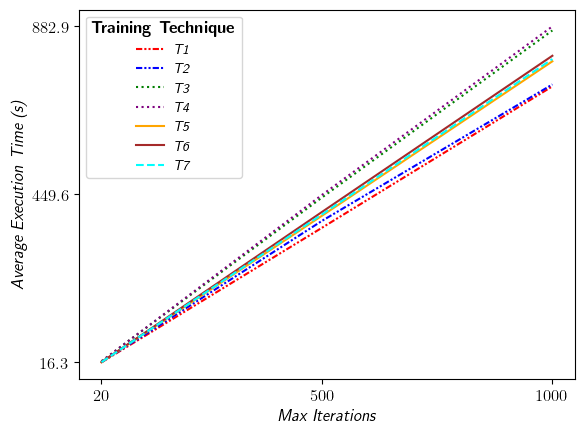

Pendientes medias por training\_type del breast dataset:
T1: 0.7241423563416642
T2: 0.7451048719772296
T3: 0.8826720241355543
T4: 0.8911905779888881
T5: 0.7930555540500045
T6: 0.8043124441466674
T7: 0.7956024562672269


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo CSV específico para 'breast'
csv_file = './results/times_avg/breast_avg_execution_times.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Filtrar por n_particle=100
filtered_df = df[df['n_particle'] == 100]

# Mapeo de los nombres de training_type a T1-T7
type_mapping = {
    'exchange_layers': 'T1',
    'individual_layers': 'T2',
    'training_exchange_layers': 'T3',
    'training_exchange_layers_e': 'T4',
    'no_individual_layers': 'T5',
    'no_exchange_layers': 'T6',
    'one_individual_layers': 'T7',
}

# Colores específicos para cada tipo
color_mapping = {
    'T1': 'red',
    'T2': 'blue',
    'T3': 'green',
    'T4': 'purple',
    'T5': 'orange',
    'T6': 'brown',
    'T7': 'cyan',
}

# Estilos de línea específicos para cada tipo
line_style_mapping = {
    'T1': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T2': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T3': 'dotted',  # Punteado
    'T4': 'dotted',  # Punteado
    'T5': '-',  # Línea sólida
    'T6': '-',  # Línea sólida
    'T7': '--',  # Línea entrecortada
}

# Configuración de LaTeX en Matplotlib
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 12,
    'legend.fontsize': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'pgf.rcfonts': False,
})

plt.figure()  # Ajustar tamaño si es necesario figsize=(10, 8)

# Graficar
for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    label = r'\textit{' + type_mapping.get(training_type, training_type) + '}'
    color = color_mapping.get(type_mapping.get(training_type, training_type), 'gray')  # Usar color asignado, o gris si no se encuentra
    line_style = line_style_mapping.get(type_mapping.get(training_type, training_type), '-')  # Usar estilo de línea asignado
    plt.plot(subset['max_iter'], subset['avg_exe'], label=label, color=color, linestyle=line_style)

# Establecer límites y ticks en el eje X
x_min, x_max = filtered_df['max_iter'].min(), filtered_df['max_iter'].max()
#plt.xticks([x_min, (x_min + x_max) / 2, x_max])
plt.xticks([20, 500, 1000])

# Establecer límites y ticks en el eje Y
y_min, y_max = filtered_df['avg_exe'].min(), filtered_df['avg_exe'].max()
plt.yticks([y_min, (y_min + y_max) / 2, y_max])

plt.xlabel(r'\textit{Max Iterations}')
plt.ylabel(r'\textit{Average Execution Time (s)}')
#plt.title(r'\textbf{Average Execution Time by Max Iterations for Breast Dataset (n\_particle=100)}')
plt.legend(title=r'\textbf{Training Technique}')
#plt.grid(True)
plt.show()

# Calcular las pendientes medias:
print(r"Pendientes medias por training\_type del breast dataset:")

for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    subset = subset.sort_values(by='max_iter')
    x = subset['max_iter'].values
    y = subset['avg_exe'].values
    
    dx = np.diff(x).astype(float)
    dy = np.diff(y)
    
    pendientes = dy / dx
    pendiente_media = np.nanmean(pendientes)
    
    print(f"{type_mapping.get(training_type, training_type)}: {pendiente_media}")


### Circle

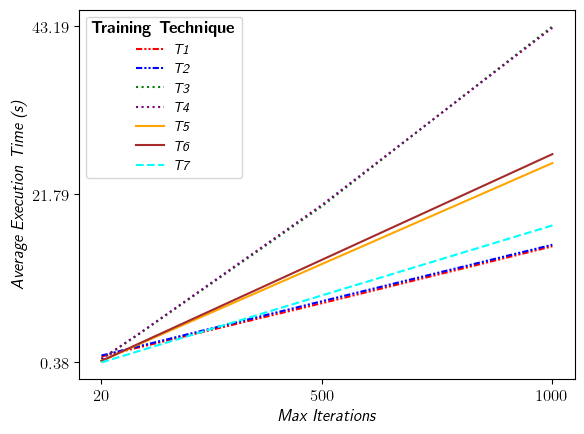

Pendientes medias por training\_type del circle dataset:
T1: 0.014252198726115177
T2: 0.014411650402221553
T3: 0.0403056335533328
T4: 0.040526062504996234
T5: 0.02602047535499793
T6: 0.026868118954439624
T7: 0.017816174282224626


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo CSV específico para 'circle'
csv_file = './results/times_avg/circle_avg_execution_times.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Filtrar por n_particle=100
filtered_df = df[df['n_particle'] == 100]

# Mapeo de los nombres de training_type a T1-T7
type_mapping = {
    'exchange_layers': 'T1',
    'individual_layers': 'T2',
    'training_exchange_layers': 'T3',
    'training_exchange_layers_e': 'T4',
    'no_individual_layers': 'T5',
    'no_exchange_layers': 'T6',
    'one_individual_layers': 'T7',
}

# Colores específicos para cada tipo
color_mapping = {
    'T1': 'red',
    'T2': 'blue',
    'T3': 'green',
    'T4': 'purple',
    'T5': 'orange',
    'T6': 'brown',
    'T7': 'cyan',
}

# Estilos de línea específicos para cada tipo
line_style_mapping = {
    'T1': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T2': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T3': 'dotted',  # Punteado
    'T4': 'dotted',  # Punteado
    'T5': '-',  # Línea sólida
    'T6': '-',  # Línea sólida
    'T7': '--',  # Línea entrecortada
}

# Configuración de LaTeX en Matplotlib
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 12,
    'legend.fontsize': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'pgf.rcfonts': False,
})

plt.figure()  # Ajustar tamaño si es necesario

# Graficar
for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    label = r'\textit{' + type_mapping.get(training_type, training_type) + '}'
    color = color_mapping.get(type_mapping.get(training_type, training_type), 'gray')  # Usar color asignado, o gris si no se encuentra
    line_style = line_style_mapping.get(type_mapping.get(training_type, training_type), '-')  # Usar estilo de línea asignado
    plt.plot(subset['max_iter'], subset['avg_exe'], label=label, color=color, linestyle=line_style)

# Establecer límites y ticks en el eje X
x_min, x_max = filtered_df['max_iter'].min(), filtered_df['max_iter'].max()
plt.xticks([20, 500, 1000])

# Establecer límites y ticks en el eje Y
y_min, y_max = filtered_df['avg_exe'].min(), filtered_df['avg_exe'].max()
plt.yticks([y_min, (y_min + y_max) / 2, y_max])

plt.xlabel(r'\textit{Max Iterations}')
plt.ylabel(r'\textit{Average Execution Time (s)}')
plt.legend(title=r'\textbf{Training Technique}')
#plt.grid(True)
plt.show()

# Calcular las pendientes medias:
print(r"Pendientes medias por training\_type del circle dataset:")

for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    subset = subset.sort_values(by='max_iter')
    x = subset['max_iter'].values
    y = subset['avg_exe'].values
    
    dx = np.diff(x).astype(float)
    dy = np.diff(y)
    
    pendientes = dy / dx
    pendiente_media = np.nanmean(pendientes)
    
    print(f"{type_mapping.get(training_type, training_type)}: {pendiente_media}")


### Iris

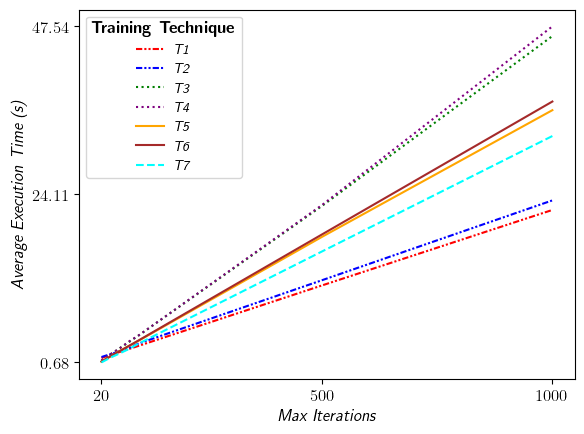

Pendientes medias por training\_type del iris dataset:
T1: 0.020953158054999994
T2: 0.022956188661112042
T3: 0.04439852324444757
T4: 0.04466606240222282
T5: 0.03593335336499994
T6: 0.036696947247222174
T7: 0.03237149169166689


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo CSV específico para 'iris'
csv_file = './results/times_avg/iris_avg_execution_times.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Filtrar por n_particle=100
filtered_df = df[df['n_particle'] == 100]

# Mapeo de los nombres de training_type a T1-T7
type_mapping = {
    'exchange_layers': 'T1',
    'individual_layers': 'T2',
    'training_exchange_layers': 'T3',
    'training_exchange_layers_e': 'T4',
    'no_individual_layers': 'T5',
    'no_exchange_layers': 'T6',
    'one_individual_layers': 'T7',
}

# Colores específicos para cada tipo
color_mapping = {
    'T1': 'red',
    'T2': 'blue',
    'T3': 'green',
    'T4': 'purple',
    'T5': 'orange',
    'T6': 'brown',
    'T7': 'cyan',
}

# Estilos de línea específicos para cada tipo
line_style_mapping = {
    'T1': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T2': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T3': 'dotted',  # Punteado
    'T4': 'dotted',  # Punteado
    'T5': '-',  # Línea sólida
    'T6': '-',  # Línea sólida
    'T7': '--',  # Línea entrecortada
}

# Configuración de LaTeX en Matplotlib
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 12,
    'legend.fontsize': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'pgf.rcfonts': False,
})

plt.figure()  # Ajustar tamaño si es necesario

# Graficar
for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    label = r'\textit{' + type_mapping.get(training_type, training_type) + '}'
    color = color_mapping.get(type_mapping.get(training_type, training_type), 'gray')  # Usar color asignado, o gris si no se encuentra
    line_style = line_style_mapping.get(type_mapping.get(training_type, training_type), '-')  # Usar estilo de línea asignado
    plt.plot(subset['max_iter'], subset['avg_exe'], label=label, color=color, linestyle=line_style)

# Establecer límites y ticks en el eje X
x_min, x_max = filtered_df['max_iter'].min(), filtered_df['max_iter'].max()
plt.xticks([20, 500, 1000])

# Establecer límites y ticks en el eje Y
y_min, y_max = filtered_df['avg_exe'].min(), filtered_df['avg_exe'].max()
plt.yticks([y_min, (y_min + y_max) / 2, y_max])

plt.xlabel(r'\textit{Max Iterations}')
plt.ylabel(r'\textit{Average Execution Time (s)}')
plt.legend(title=r'\textbf{Training Technique}')
#plt.grid(True)
plt.show()

# Calcular las pendientes medias:
print(r"Pendientes medias por training\_type del iris dataset:")

for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    subset = subset.sort_values(by='max_iter')
    x = subset['max_iter'].values
    y = subset['avg_exe'].values
    
    dx = np.diff(x).astype(float)
    dy = np.diff(y)
    
    pendientes = dy / dx
    pendiente_media = np.nanmean(pendientes)
    
    print(f"{type_mapping.get(training_type, training_type)}: {pendiente_media}")


### Wine

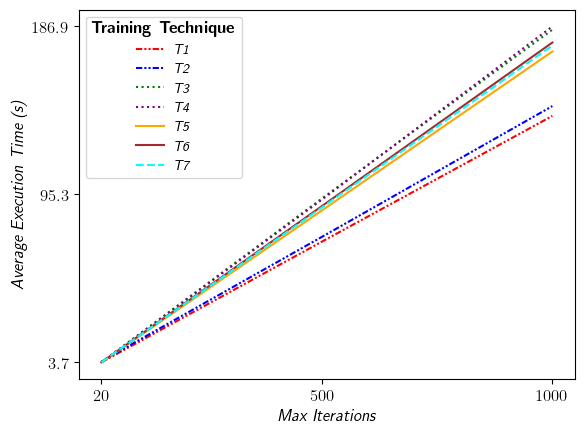

Pendientes medias por training\_type del wine dataset:
T1: 0.1369354884683326
T2: 0.14450059057166456
T3: 0.18579851648166443
T4: 0.18366910470111372
T5: 0.17295902733388813
T6: 0.177543634273888
T7: 0.17603320656055496


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo CSV específico para 'wine'
csv_file = './results/times_avg/wine_avg_execution_times.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Filtrar por n_particle=100
filtered_df = df[df['n_particle'] == 100]

# Mapeo de los nombres de training_type a T1-T7
type_mapping = {
    'exchange_layers': 'T1',
    'individual_layers': 'T2',
    'training_exchange_layers': 'T3',
    'training_exchange_layers_e': 'T4',
    'no_individual_layers': 'T5',
    'no_exchange_layers': 'T6',
    'one_individual_layers': 'T7',
}

# Colores específicos para cada tipo
color_mapping = {
    'T1': 'red',
    'T2': 'blue',
    'T3': 'green',
    'T4': 'purple',
    'T5': 'orange',
    'T6': 'brown',
    'T7': 'cyan',
}

# Estilos de línea específicos para cada tipo
line_style_mapping = {
    'T1': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T2': (0, (3, 1, 1, 1, 1, 1)),  # Densamente guión-punto-punto
    'T3': 'dotted',  # Punteado
    'T4': 'dotted',  # Punteado
    'T5': '-',  # Línea sólida
    'T6': '-',  # Línea sólida
    'T7': '--',  # Línea entrecortada
}

# Configuración de LaTeX en Matplotlib
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 12,
    'legend.fontsize': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'pgf.rcfonts': False,
})

plt.figure()  # Ajustar tamaño si es necesario

# Graficar
for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    label = r'\textit{' + type_mapping.get(training_type, training_type) + '}'
    color = color_mapping.get(type_mapping.get(training_type, training_type), 'gray')  # Usar color asignado, o gris si no se encuentra
    line_style = line_style_mapping.get(type_mapping.get(training_type, training_type), '-')  # Usar estilo de línea asignado
    plt.plot(subset['max_iter'], subset['avg_exe'], label=label, color=color, linestyle=line_style)

# Establecer límites y ticks en el eje X
x_min, x_max = filtered_df['max_iter'].min(), filtered_df['max_iter'].max()
plt.xticks([20, 500, 1000])

# Establecer límites y ticks en el eje Y
y_min, y_max = filtered_df['avg_exe'].min(), filtered_df['avg_exe'].max()
plt.yticks([y_min, (y_min + y_max) / 2, y_max])

plt.xlabel(r'\textit{Max Iterations}')
plt.ylabel(r'\textit{Average Execution Time (s)}')
plt.legend(title=r'\textbf{Training Technique}')
#plt.grid(True)
plt.show()

# Calcular las pendientes medias:
print(r"Pendientes medias por training\_type del wine dataset:")

for training_type in filtered_df['training_type'].unique():
    subset = filtered_df[filtered_df['training_type'] == training_type]
    subset = subset.sort_values(by='max_iter')
    x = subset['max_iter'].values
    y = subset['avg_exe'].values
    
    dx = np.diff(x).astype(float)
    dy = np.diff(y)
    
    pendientes = dy / dx
    pendiente_media = np.nanmean(pendientes)
    
    print(f"{type_mapping.get(training_type, training_type)}: {pendiente_media}")


### std heatmap

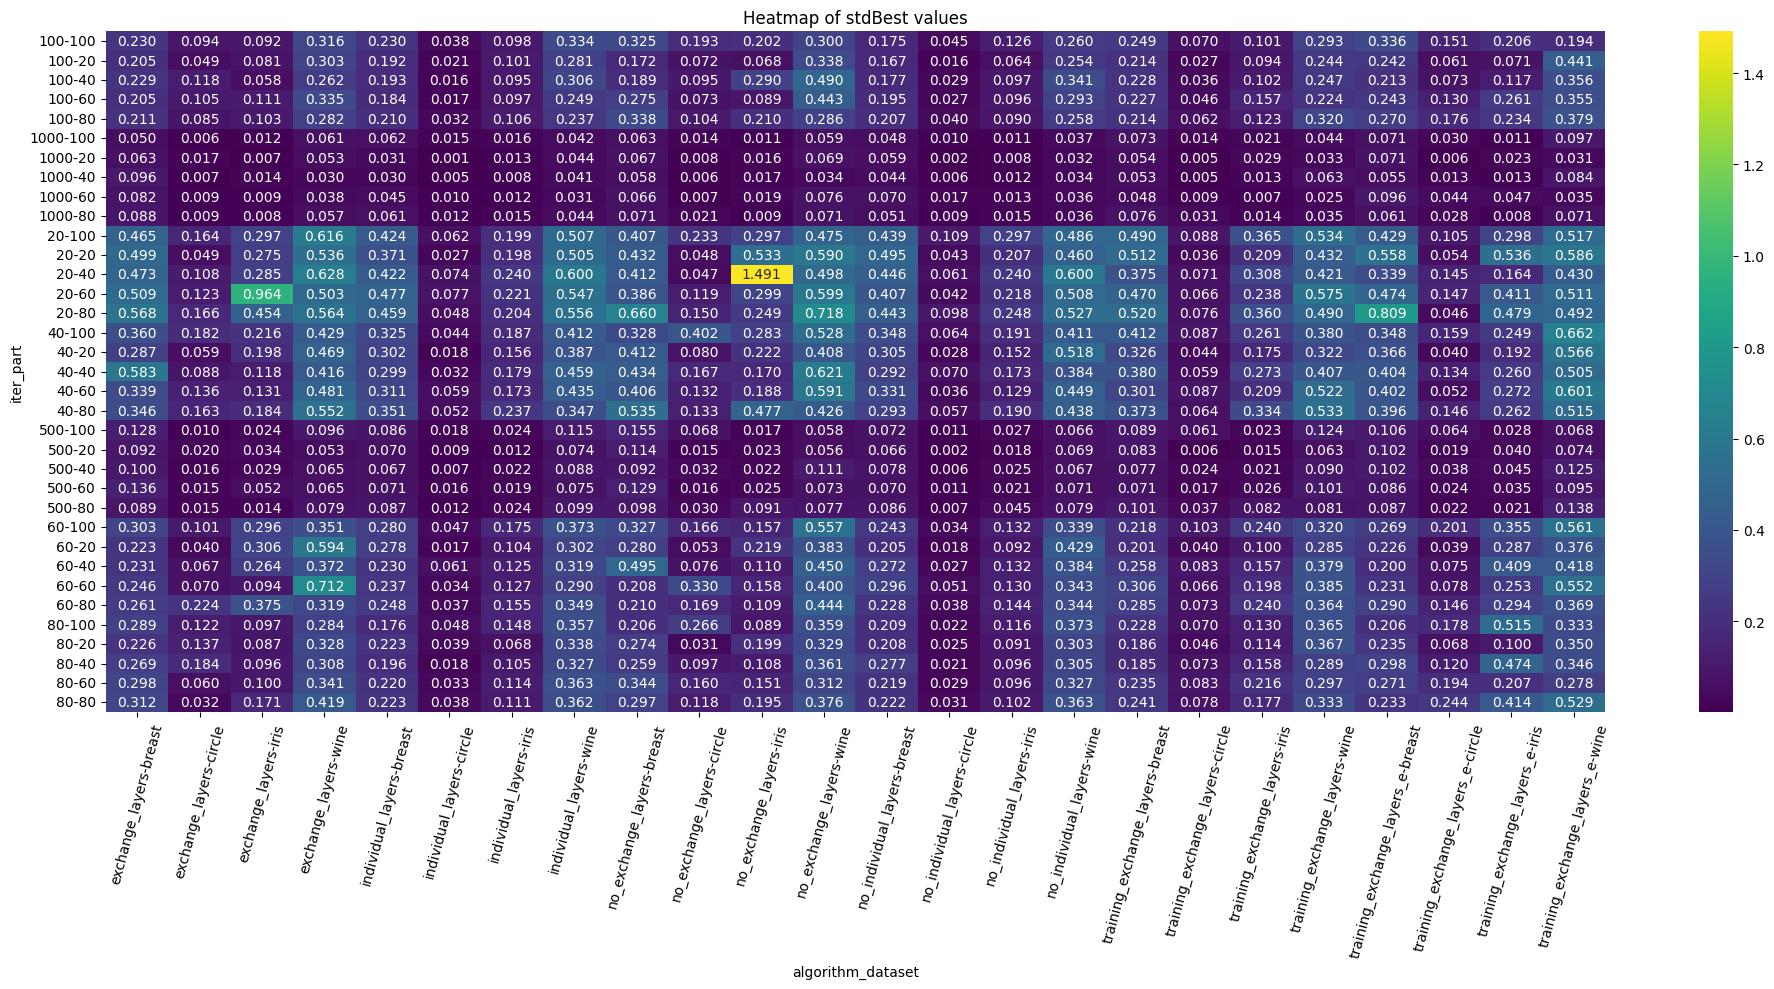

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leyendo el CSV
df = pd.read_csv("./results/stdBest_avg/avg_stdBest_values.csv")

# Preparando los datos para los ejes
df['algorithm_dataset'] = df['training_type'] + "-" + df['data_name']
df['iter_part'] = df['max_iter'].astype(str) + "-" + df['n_particle'].astype(str)

# Pivotando la tabla para el heatmap
pivot_df = df.pivot_table(index='iter_part', columns='algorithm_dataset', values='stdBest', aggfunc='first')

# Creando el heatmap
plt.figure(figsize=(20, 10))  # Ajusta este tamaño según sea necesario
ax = sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="viridis")
plt.title("Heatmap of stdBest values")

# Ajustando las etiquetas del eje X
ax.set_xticklabels(pivot_df.columns, rotation=75)  # Alineación a la izquierda

plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) se ajuste al área de la figura
plt.show()


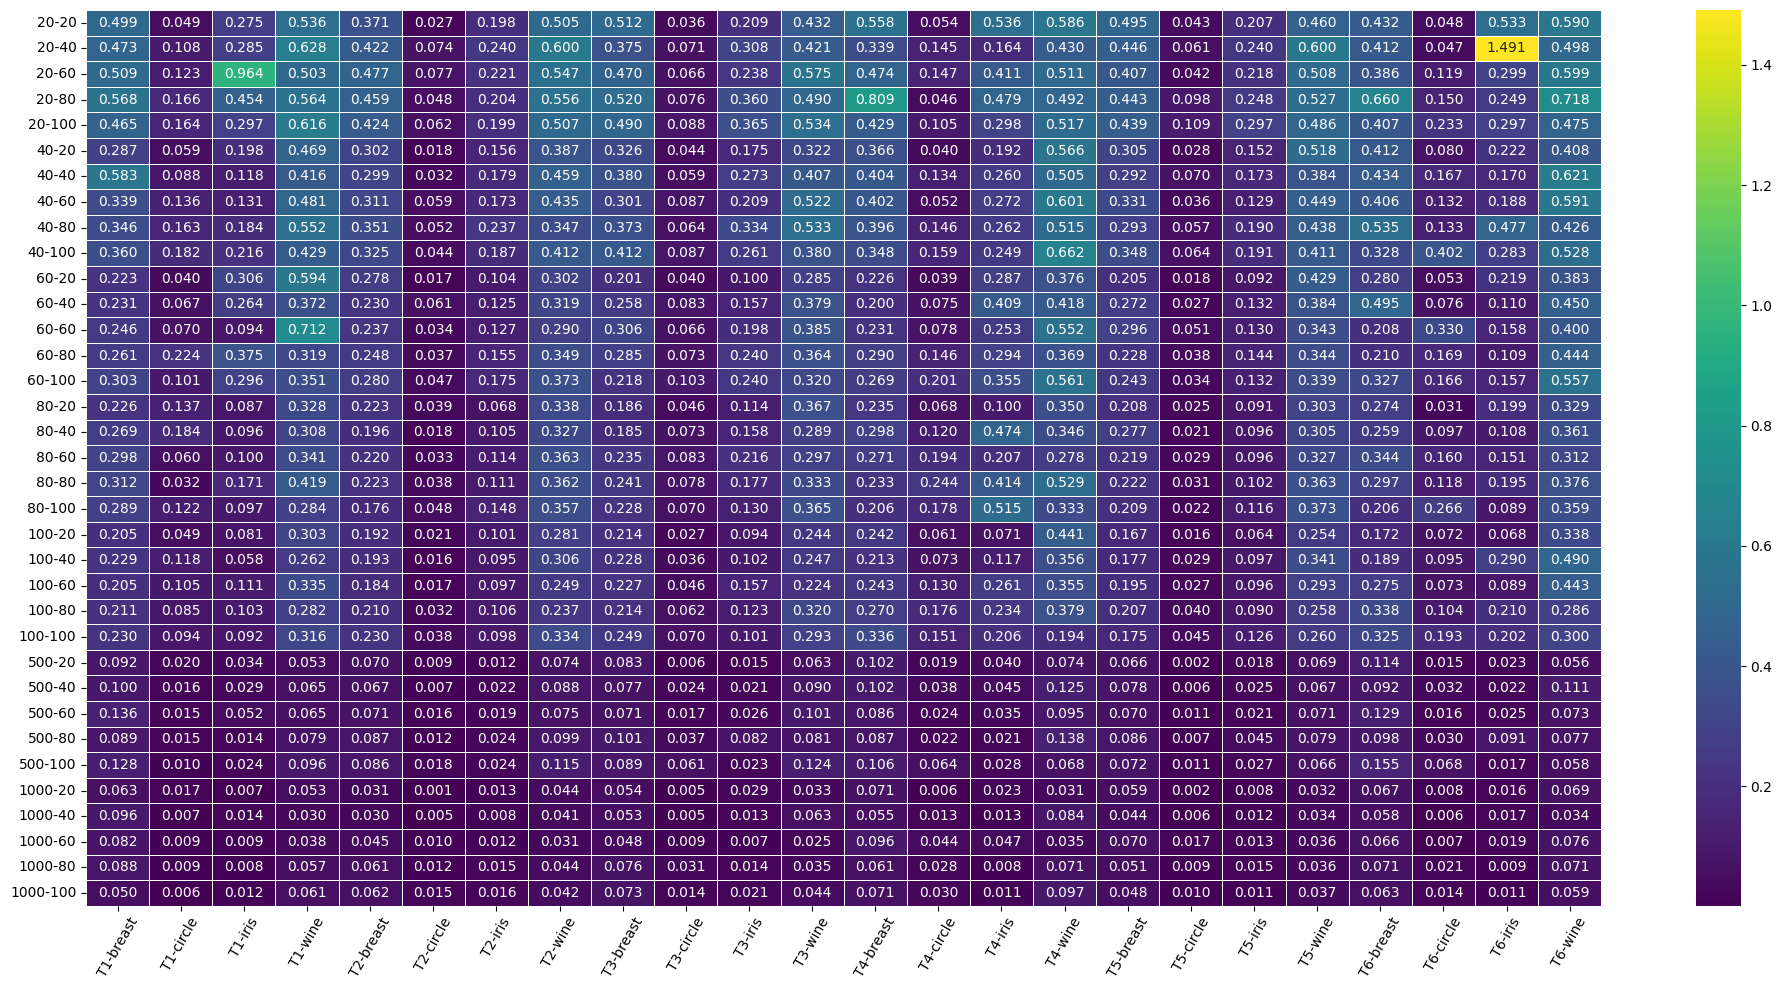

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leyendo el CSV
df = pd.read_csv("./results/stdBest_avg/avg_stdBest_values.csv")

# Creando las combinaciones únicas para las columnas y filas, manteniendo el orden
df['algorithm_dataset'] = df['training_type'] + "-" + df['data_name']
df['iter_part'] = df['max_iter'].astype(str) + "-" + df['n_particle'].astype(str)

# Inicializar listas para mantener el orden de aparición
iter_parts_ordered = []
algorithms_datasets_ordered = []

for index, row in df.iterrows():
    iter_part = row['iter_part']
    algorithm_dataset = row['algorithm_dataset']
    
    if iter_part not in iter_parts_ordered:
        iter_parts_ordered.append(iter_part)
        
    if algorithm_dataset not in algorithms_datasets_ordered:
        algorithms_datasets_ordered.append(algorithm_dataset)

# Crear el DataFrame vacío con índices y columnas basadas en el orden de aparición
data_matrix = pd.DataFrame(index=iter_parts_ordered, columns=algorithms_datasets_ordered)

# Llenar el DataFrame
for index, row in df.iterrows():
    data_matrix.at[row['iter_part'], row['algorithm_dataset']] = row['stdBest']

# Convirtiendo todos los valores de data_matrix a flotantes
data_matrix = data_matrix.applymap(pd.to_numeric, errors='coerce')

# Mapeo directo de nombres de algoritmos a 'AlgX'
algorithm_names = [
    'exchange_layers',
    'individual_layers',
    'training_exchange_layers',
    'training_exchange_layers_e',
    'no_individual_layers',
    'no_exchange_layers'
]
algorithm_replacements = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']

algorithm_mapping = {name: replacement for name, replacement in zip(algorithm_names, algorithm_replacements)}

# Aplicando el mapeo directo a las columnas del DataFrame
data_matrix.columns = [algorithm_mapping.get(name.split('-')[0], name) + '-' + name.split('-')[1] for name in data_matrix.columns]

# Creando el heatmap con los nombres de columnas actualizados
plt.figure(figsize=(20, 10))  # Ajusta este tamaño según sea necesario
ax = sns.heatmap(data_matrix, annot=True, fmt=".3f", cmap="viridis", linewidths=.5)

#plt.title("Heatmap of stdBest values")

# Ajustando las etiquetas del eje X con los nuevos nombres
ax.set_xticklabels(data_matrix.columns, rotation=60)

# Las etiquetas del eje Y permanecen sin cambios
ax.set_yticklabels(data_matrix.index, rotation=0)

plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) se ajuste al área de la figura
plt.show()

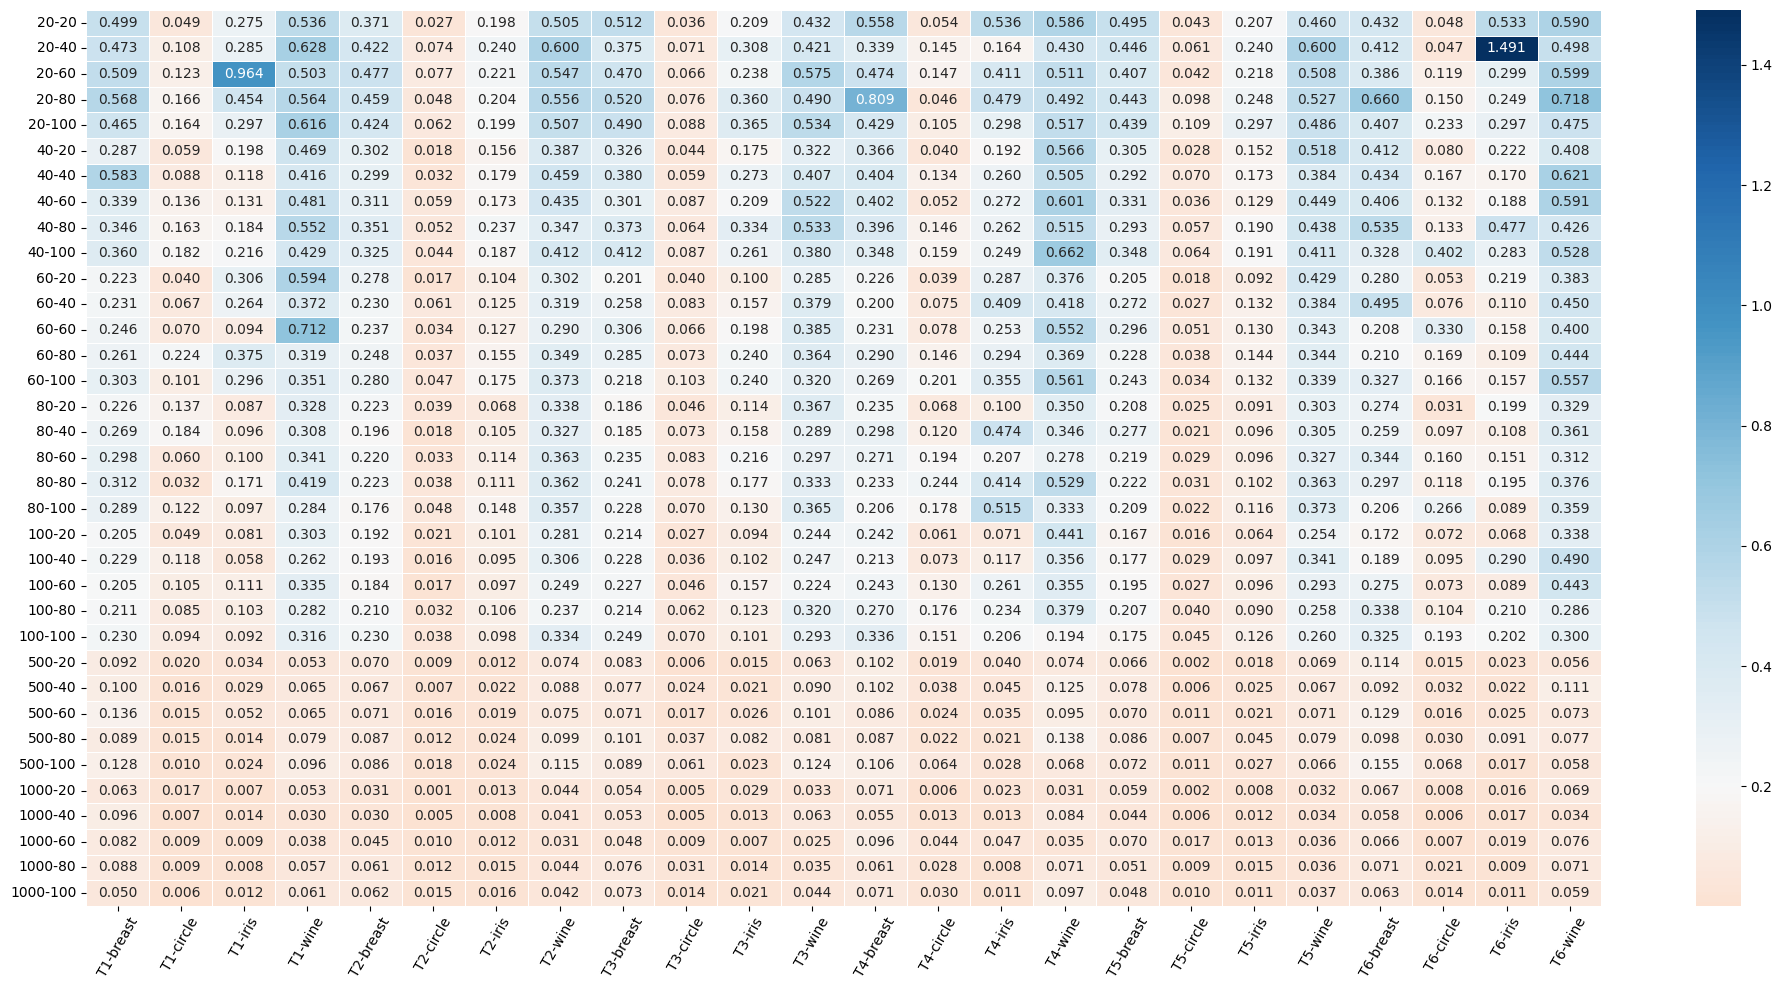

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leyendo el CSV
df = pd.read_csv("./results/stdBest_avg/avg_stdBest_values.csv")

# Creando las combinaciones únicas para las columnas y filas, manteniendo el orden
df['algorithm_dataset'] = df['training_type'] + "-" + df['data_name']
df['iter_part'] = df['max_iter'].astype(str) + "-" + df['n_particle'].astype(str)

# Inicializar listas para mantener el orden de aparición
iter_parts_ordered = []
algorithms_datasets_ordered = []

for index, row in df.iterrows():
    iter_part = row['iter_part']
    algorithm_dataset = row['algorithm_dataset']
    
    if iter_part not in iter_parts_ordered:
        iter_parts_ordered.append(iter_part)
        
    if algorithm_dataset not in algorithms_datasets_ordered:
        algorithms_datasets_ordered.append(algorithm_dataset)

# Crear el DataFrame vacío con índices y columnas basadas en el orden de aparición
data_matrix = pd.DataFrame(index=iter_parts_ordered, columns=algorithms_datasets_ordered)

# Llenar el DataFrame
for index, row in df.iterrows():
    data_matrix.at[row['iter_part'], row['algorithm_dataset']] = row['stdBest']

# Convirtiendo todos los valores de data_matrix a flotantes
data_matrix = data_matrix.applymap(pd.to_numeric, errors='coerce')

# Mapeo directo de nombres de algoritmos a 'AlgX'
algorithm_names = [
    'exchange_layers',
    'individual_layers',
    'training_exchange_layers',
    'training_exchange_layers_e',
    'no_individual_layers',
    'no_exchange_layers'
]
algorithm_replacements = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']

algorithm_mapping = {name: replacement for name, replacement in zip(algorithm_names, algorithm_replacements)}

# Aplicando el mapeo directo a las columnas del DataFrame
data_matrix.columns = [algorithm_mapping.get(name.split('-')[0], name) + '-' + name.split('-')[1] for name in data_matrix.columns]

# Creando el heatmap con los nombres de columnas actualizados
plt.figure(figsize=(20, 10))  # Ajusta este tamaño según sea necesario
ax = sns.heatmap(data_matrix, annot=True, fmt=".3f", cmap="RdBu", center=data_matrix.mean().mean(), linewidths=.5)

# Ajustando las etiquetas del eje X con los nuevos nombres
ax.set_xticklabels(data_matrix.columns, rotation=60)

# Las etiquetas del eje Y permanecen sin cambios
ax.set_yticklabels(data_matrix.index, rotation=0)

plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) se ajuste al área de la figura
plt.show()


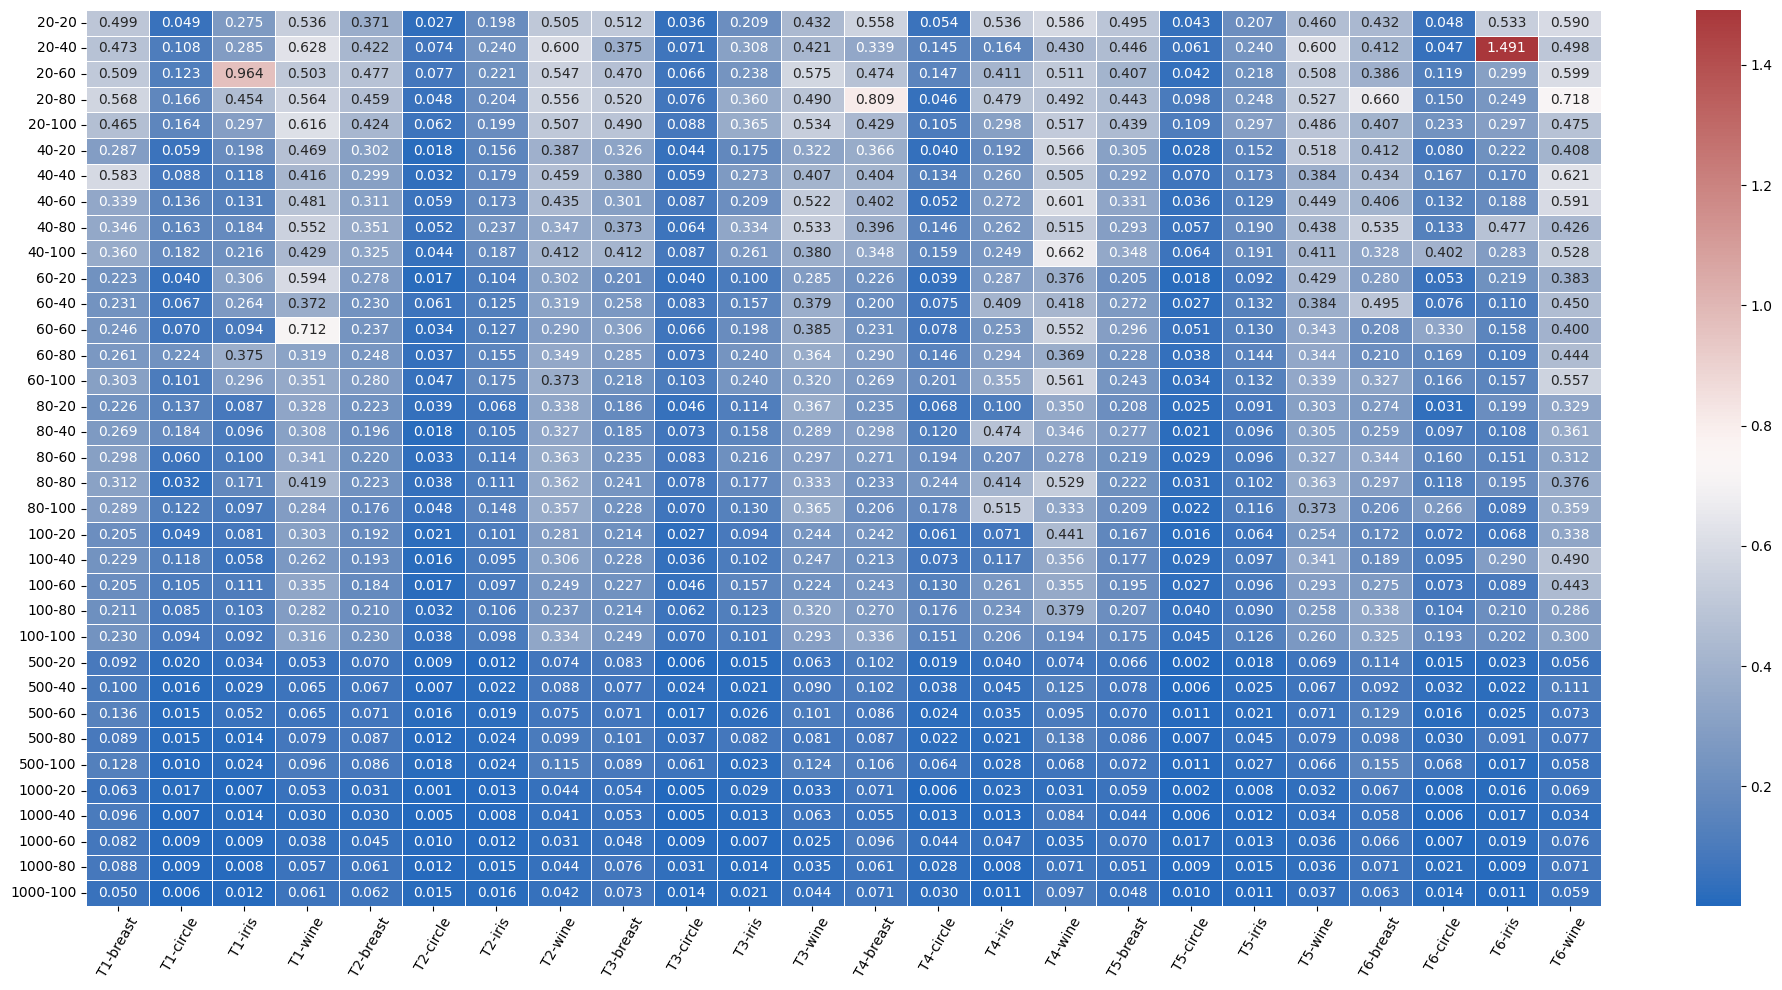

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Leyendo el CSV
df = pd.read_csv("./results/stdBest_avg/avg_stdBest_values.csv")

# Creando las combinaciones únicas para las columnas y filas, manteniendo el orden
df['algorithm_dataset'] = df['training_type'] + "-" + df['data_name']
df['iter_part'] = df['max_iter'].astype(str) + "-" + df['n_particle'].astype(str)

# Inicializar listas para mantener el orden de aparición
iter_parts_ordered = []
algorithms_datasets_ordered = []

for index, row in df.iterrows():
    iter_part = row['iter_part']
    algorithm_dataset = row['algorithm_dataset']
    
    if iter_part not in iter_parts_ordered:
        iter_parts_ordered.append(iter_part)
        
    if algorithm_dataset not in algorithms_datasets_ordered:
        algorithms_datasets_ordered.append(algorithm_dataset)

# Crear el DataFrame vacío con índices y columnas basadas en el orden de aparición
data_matrix = pd.DataFrame(index=iter_parts_ordered, columns=algorithms_datasets_ordered)

# Llenar el DataFrame
for index, row in df.iterrows():
    data_matrix.at[row['iter_part'], row['algorithm_dataset']] = row['stdBest']

# Convirtiendo todos los valores de data_matrix a flotantes
data_matrix = data_matrix.applymap(pd.to_numeric, errors='coerce')

# Mapeo directo de nombres de algoritmos a 'AlgX'
algorithm_names = [
    'exchange_layers',
    'individual_layers',
    'training_exchange_layers',
    'training_exchange_layers_e',
    'no_individual_layers',
    'no_exchange_layers'
]
algorithm_replacements = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']

algorithm_mapping = {name: replacement for name, replacement in zip(algorithm_names, algorithm_replacements)}

# Aplicando el mapeo directo a las columnas del DataFrame
data_matrix.columns = [algorithm_mapping.get(name.split('-')[0], name) + '-' + name.split('-')[1] for name in data_matrix.columns]

# Definiendo los límites para los colores en el heatmap
#min_val = data_matrix.min().min()
#max_val = data_matrix.max().max()
#mid_val = data_matrix.mean().mean()

# Custome colors
# Creando la paleta de colores personalizada
#custom_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True) # green to magenta
#custom_cmap = sns.diverging_palette(220, 20, as_cmap=True) # near to blue to red

# Creando el heatmap con los nombres de columnas actualizados
plt.figure(figsize=(20, 10))  # Ajusta este tamaño según sea necesario
ax = sns.heatmap(data_matrix, annot=True, fmt=".3f", cmap='vlag', linewidths=.5) #  center=mid_val, vmin=min_val, vmax=max_val,

# Ajustando las etiquetas del eje X con los nuevos nombres
ax.set_xticklabels(data_matrix.columns, rotation=60)

# Las etiquetas del eje Y permanecen sin cambios
ax.set_yticklabels(data_matrix.index, rotation=0)

plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) se ajuste al área de la figura
plt.savefig('./results/stdBest_avg/heatmap_stdBest_values.png')
plt.show()
